# Predicting Heart Disease Using Classification
#### Group 11: Cameron Geisler, Daisy Liu, Nima Zareian, Sean Chung
## Introduction
This project will use [Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease), which describes the various attributes, symptoms and observations seen on patients in the process of being diagnosed with cardiovascular diseases. 
<br> <br>
Specifically, the project will be using a [processed version](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data) of said data containing information documented by the Cleveland Foundation, which is the most complete out of all given options.
<br> <br>
Diagnosis for cardiovascular diseases are often based on direct examinations of the heart done through the use of electrocardiograms (measures heart beat rhythms) and echocardiograms (measures the heart's physical state with ultrasound).
<br> <br>
Aside from these direct testing methods, there are other health metrics which can be used to help predict heart disease. Incidentally, almost half of all heart attacks experienced by people were unanticipated due to the presence of asymptomatic heart diseases, that is, heart diseases with little to no experience based indicators, and are thus difficult to notice and diagnose.

<b>Predictive question:</b> Given easily measured health indicators, such as age, heart rate, blood pressure, and/or cholesterol levels, what is the status of patients' heart disease (present/absent)?
<br><br>


## Methods and Results

First, we load the necessary packages.

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(tidymodels)))
suppressWarnings(suppressMessages(library(repr)))
suppressWarnings(suppressMessages(library(GGally)))
options(repr.matrix.max.rows = 6)

Next, we load the dataset from the [URL](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data).

In [2]:
# Load the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
data_raw <- read_csv(url, col_names = names)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



The data is already in a tidy format. However, we will make some small changes such as making the column names more descriptive and human readable, and converting the columns to the correct data type. In this analysis we will use the variables: age (years), resting blood pressure (mmHg), cholesterol level (mg/dL), and heart rate (bpm) to predict the presence of heart disease in a patient.

In [3]:
# Wrangle data
heart_data <- data_raw %>%
    select(c("age", "trestbps", "thalach", "chol", "num")) %>% # select only columns that are used
    mutate(num = as_factor(num)) %>% # update target variables to factor
    rename(heart_disease = num, # rename some columns with more intuitive names
          rest_bp = trestbps,
          max_heart_rate = thalach)

In the original data, there are five levels of heart disease (labelled 0, 1, 2, 3, 4), which varying degrees of disease, from "no visible heart disease" to "very severe heart disease". We combine levels 1-4, in order to simply classify the observations as having heart diesease (labelled as "Yes") or not (labelled as "No").

In [4]:
heart_data <- heart_data %>%
    mutate(heart_disease = as_factor(ifelse(heart_disease == 0, "No", "Yes")))
head(heart_data)

age,rest_bp,max_heart_rate,chol,heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,150,233,No
67,160,108,286,Yes
67,120,129,229,Yes
37,130,187,250,No
41,130,172,204,No
56,120,178,236,No


Here, we split the data into training and testing set. The training set will be used to train the K-nearest neighbors model, and the model's accuracy will be measured by applying it to the testing set.

In [5]:
set.seed(1) # set the seed

heart_split = initial_split(heart_data, prop = 0.75, strata = heart_disease)
heart_training = training(heart_split)
heart_testing = testing(heart_split)

Below we can see that the training and testing datasets are stratified since they have almost identical ratio of observations with and without heart disease. This is important as it allows us to have equal representation of both types of observations in our training and testing dataset.

In [6]:
# Training dataset summary
heart_training %>%
    group_by(heart_disease) %>%
    summarize(n = n(), .groups = "drop") %>%
    mutate(percent = n / nrow(heart_training))

heart_disease,n,percent
<fct>,<int>,<dbl>
No,123,0.5394737
Yes,105,0.4605263


In [7]:
# Testing dataset summary
heart_testing %>%
    group_by(heart_disease) %>%
    summarize(n = n(), .groups = "drop") %>%
    mutate(percent = n / nrow(heart_testing))

heart_disease,n,percent
<fct>,<int>,<dbl>
No,41,0.5466667
Yes,34,0.4533333


Figure 1 shows the relative proportion of individuals with and without heart disease in the data set. Notice that the proportions are roughly equal in each category, as a result, we do not need to balance our dataset as there is a fair representation of both observations.
> Could combine this with the outputs above which also show us the precentage.

> Should we balance our dataset? is 45% to 55% "balance enough"?

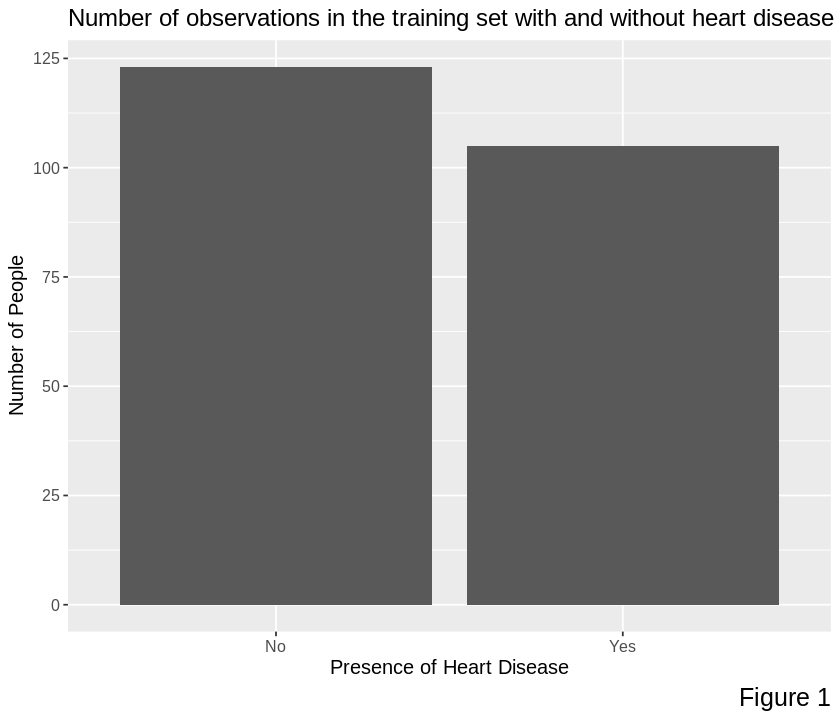

In [8]:
options(repr.plot.width = 7, repr.plot.height = 6)

ggplot(heart_training, aes(x = heart_disease)) +
    geom_bar() +
    xlab("Presence of Heart Disease") +
    ylab("Number of People") +
    ggtitle("Number of observations in the training set with and without heart disease") + 
    labs(caption = "Figure 1") + 
    theme(
      text = element_text(size = 12),
      plot.caption = element_text(size = 15)
    )

Below are histograms for the four possible predictor variables: age, blood cholesterol, maximum heart rate, and resting blood pressure. Each of the graphs are split up into the groups of people who have heart disease (in blue) and those who don't (in red).
<br><br>
For each variable, we can roughly compare the distribution between the heart disease and non-heart disease group, to see if the variable seems to be associated with the presence of heart disease. From these plots, it seems that age, resting blood pressure, and cholesterol are positively associated with heart disease (although only slightly), and maximum heart rate is negatively associated with heart disease.

> Age and max heart rate seem to be the two predictors which show the largest difference in terms of the presense of heart disease. Should we limit our project to just those two? 

Below are scatterplots for every possible pair of predictor variables. However, there isn't a clear pattern for each pair of variables, besides the small patterns for the individual variables.

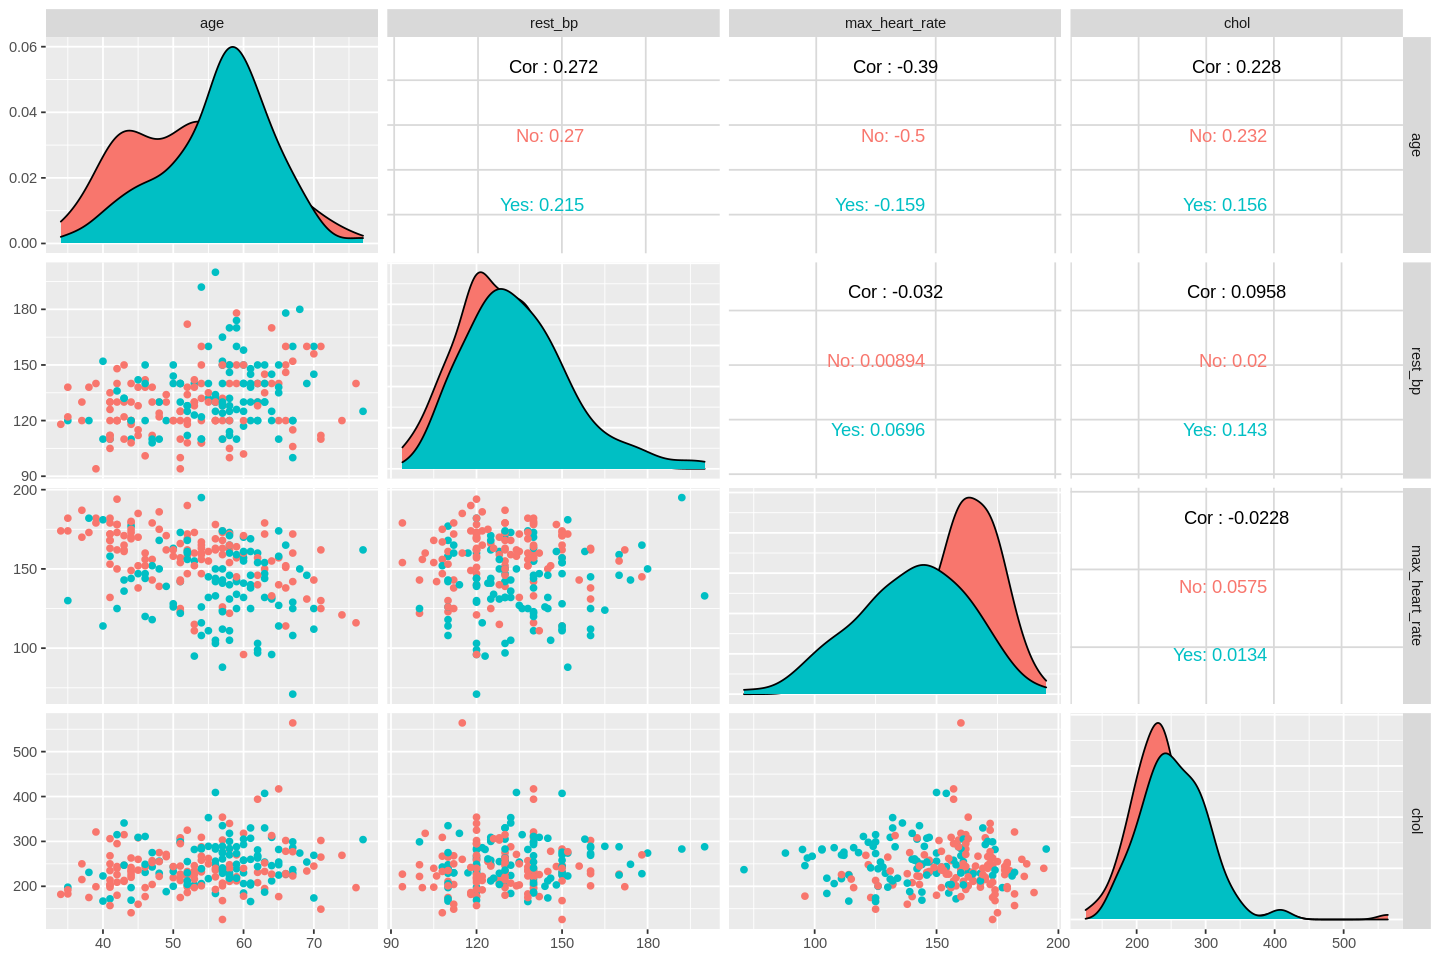

In [9]:
options(repr.plot.width = 12, repr.plot.height = 8)
# theme_set(theme_gray(base_size = 18))
# bins_num = ceiling(log(nrow(data),2))+1 # number of bins, by Sturges' formula

# Histograms for predictor variables
# Scatterplots for every possible combination of predictor variables
ggpairs(heart_training, mapping = aes(color = heart_disease), columns = 1:4)

## Methods

We will use K-nearest neighbors classification, with predictor variables of age, resting blood pressure, maximum heart rate, and blood cholesterol, and target variable of the diagnosis of heart disease. We will use a training set, and further split the data set to perform cross-validation.

To visualize the results, we could use a confusion matrix in order to understand the proportion of false positives and false negatives. If we end up using only 2 (or 3) predictors, we could use a scatterplot (or 3D scatterplot, respectively).

In [10]:
# Create a K-Nearest neighbor model for training set
recipe <- recipe(heart_disease ~ age + max_heart_rate, data = heart_training) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
         set_engine("kknn") %>%
         set_mode("classification")

In [11]:
# Find K with max accuracy
vfold <- vfold_cv(heart_training, v = 5, strata = heart_disease)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_result <- workflow() %>% 
          add_recipe(recipe) %>%
          add_model(spec) %>%
          tune_grid(resamples = vfold, grid = k_vals) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy")

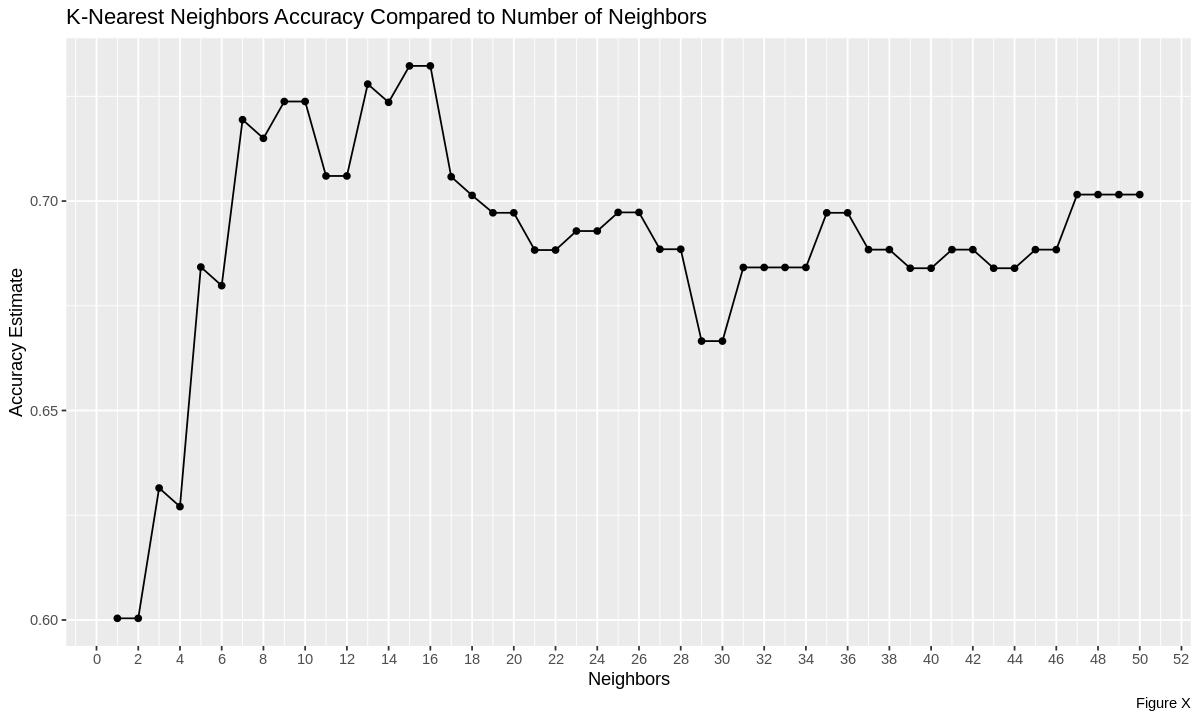

In [12]:
options(repr.plot.width = 10, repr.plot.height = 6)

accuracy_vs_k <- ggplot(knn_result, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() + 
    labs(x = "Neighbors", y = "Accuracy Estimate", caption = "Figure X") +   
    ggtitle("K-Nearest Neighbors Accuracy Compared to Number of Neighbors") +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 20))
accuracy_vs_k

In [13]:
max_accuracy <- knn_result %>%
  filter(mean == max(mean))
max_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.7322705,5,0.04272793,Model15
16,accuracy,binary,0.7322705,5,0.04272793,Model16


In [14]:
# Train model with actual K
k_max <- 10
actual_spec <- nearest_neighbor(weight_func = "rectangular", 
                                    neighbors = k_max) %>%
                                    set_engine("kknn") %>%
                                    set_mode("classification")

knn_fit <- workflow() %>%
       add_recipe(recipe) %>%  
       add_model(actual_spec) %>% 
       fit(data = heart_training)

# Predictions and accuracy
predictions <- predict(knn_fit, heart_testing) %>% 
               bind_cols(heart_testing)

accuracy <- predictions %>%
            metrics(truth = heart_disease, estimate = .pred_class) %>%
            filter(.metric == "accuracy") %>%
            select(.estimate) %>%
            pull()
accuracy

[1] 0.7333333

In [15]:
# Confusion matrix for predictions
conf_mat <- predictions %>%
    conf_mat(truth = heart_disease, estimate = .pred_class)
conf_mat

          Truth
Prediction No Yes
       No  30   9
       Yes 11  25

In [ ]:
# Prediction results plot
x_grid <- seq(min(heart_data$age), max(heart_data$age), length.out = 200)
y_grid <- seq(min(heart_data$max_heart_rate), max(heart_data$max_heart_rate), length.out = 200)
xy_grid <- as_tibble(expand.grid(age = x_grid, max_heart_rate = y_grid))
knn_pred_grid <- predict(knn_fit, xy_grid)
prediction_table <- bind_cols(knn_pred_grid, xy_grid)
options(repr.plot.width = 10, repr.plot.height = 8)

pred_plot <- ggplot() +
    geom_point(data = heart_data, mapping = aes(x = age, y = max_heart_rate, color = heart_disease), alpha = 1.5) +
    geom_point(data = prediction_table, mapping = aes(x = age, y = max_heart_rate, color = .pred_class), alpha = 0.03, size = 5) +
    labs(color = "Presence of Heart Disease", x = "Age", y = "Max Heart Rate") +
    scale_color_manual(labels = c("Yes", "No"), values = c("orange2", "steelblue2"))
pred_plot

## Expected Outcomes

<b>Expected outcomes for each target variable:</b>
Diagnosis of heart disease (no = absence, yes = presence)

1. <b> Age </b> - heart diseases are expected to be more common in older people (>65 years) since aging causes changes in the heart and blood vessels. Additionally, in the histogram above that visualize age distribution of patients with and without heart disease, there is higher mean and median age of patients with heart disease than patients without heart disease.
2. <b>Resting blood pressure</b> - we expect that high blood pressure (>130mm assumed systolic bp) will be positively associated with presence of heart disease since high blood pressure is a risk factor for heart disease. However, the histogram above visualizes only a slightly higher mean and median blood pressure for patients with heart disease compared to patients who do not, indicating that resting blood pressure may not be as valuable a predictor as other variables.
3. <b>Cholesterol</b> - we expect that high levels of cholesterol (>240mg/dL) will be positively associated with presence of heart disease since high cholesterol is known to increase risk of heart attacks. However, the histogram above visualizes only slightly higher mean cholesterol levels in patients with heart disease compared to patients without, indicating that resting blood pressure may not be as valuable a predictor as other variables.
4. <b>Maximum heart rate</b> - we expect a weak association between a high maximum heart rate and heart disease since rapid heartbeat is a symptom of coronary artery disease, however, different ages, weights, heights, affect heart rate and what constitutes “rapid heartbeat” which may weaken its relationship with the presence of heart disease. Surprisingly, the histogram above visualize a lower mean and median maximum heart rate for patients with heart disease compared to patients without. This variable shows unexpected results but may be a useful predictor as there is a significant difference between heart disease positive and negative patients using this predictor.
<br>

<b>What impact could such findings have?</b> <br>
Accurate predictions made by aforementioned indicators can greatly reduce the chance of asymptomatic heart diseases going undiagnosed as the said indicators are more conveniently measured than direct, elaborate testings on the heart which are usually only considered after the patient has expressed discomfort.
<br> <br>
<b>What future questions could this lead to?</b> <br>
Which of these predictors has the highest impact on the presence of heart disease?
Do some of these predictors facilitate asymptomatic heart disease more than symptomatic ones?


## Bibliography
“Heart Health and Aging.” National Institute on Aging, U.S. Department of Health and Human Services, 1 June 2018, https://www.nia.nih.gov/health/heart-health-and-aging.
<br><br>
Perret-Guillaume C, Joly L, Benetos A. Heart rate as a risk factor for cardiovascular disease. Prog Cardiovasc Dis. 2009 Jul-Aug;52(1):6-10. doi: 10.1016/j.pcad.2009.05.003. PMID: 19615487.
<br><br>
“Prevention of Heart Diseases and Conditions.” Canada.ca, Public Health Agency of Canada, 10 Mar. 2017, https://www.canada.ca/en/public-health/services/diseases/heart-health/heart-diseases-conditions/prevention-heart-diseases-conditions.html.

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science